In [1]:
# PTB-XL xLSTM Model
import os
import ast
import wfdb
import torch
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [2]:
# --- Dataset Preparation ---
dataset_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")
ptbxl_path = dataset_path / "ptbxl_database.csv"
waveform_path = dataset_path

df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'AFIB', 'PVC', 'LVH', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]
mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)


def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal


class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T  # [12, 5000]
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [3]:
# --- xLSTM Model ---
class xLSTMECG(nn.Module):
    def __init__(self, input_channels=12, num_classes=10, hidden_size=128, num_layers=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)  # [B, T, C]
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last time step
        return self.fc(x)

In [4]:
# --- Training & Evaluation ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = xLSTMECG(input_channels=12, num_classes=len(target_labels)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses, accuracies = [], []
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for signals, labels in train_loader_tqdm:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
        train_loader_tqdm.set_postfix(loss=loss.item())
    losses.append(total_loss / len(train_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch+1}, Avg Loss: {losses[-1]:.4f}, Avg Accuracy: {accuracies[-1]:.4f}")


Epoch 1/10: 100%|██████████| 1791/1791 [01:27<00:00, 20.42it/s, loss=0.255]


Epoch 1, Avg Loss: 0.3600, Avg Accuracy: 0.8621


Epoch 2/10: 100%|██████████| 1791/1791 [01:28<00:00, 20.22it/s, loss=0.295] 


Epoch 2, Avg Loss: 0.3285, Avg Accuracy: 0.8749


Epoch 3/10: 100%|██████████| 1791/1791 [01:24<00:00, 21.22it/s, loss=0.279] 


Epoch 3, Avg Loss: 0.2843, Avg Accuracy: 0.8889


Epoch 4/10: 100%|██████████| 1791/1791 [01:24<00:00, 21.19it/s, loss=0.369] 


Epoch 4, Avg Loss: 0.2569, Avg Accuracy: 0.8985


Epoch 5/10: 100%|██████████| 1791/1791 [01:20<00:00, 22.20it/s, loss=0.35]  


Epoch 5, Avg Loss: 0.2378, Avg Accuracy: 0.9050


Epoch 6/10: 100%|██████████| 1791/1791 [01:22<00:00, 21.67it/s, loss=0.0894]


Epoch 6, Avg Loss: 0.2181, Avg Accuracy: 0.9129


Epoch 7/10: 100%|██████████| 1791/1791 [01:22<00:00, 21.65it/s, loss=0.171] 


Epoch 7, Avg Loss: 0.2039, Avg Accuracy: 0.9183


Epoch 8/10: 100%|██████████| 1791/1791 [01:27<00:00, 20.52it/s, loss=0.28]  


Epoch 8, Avg Loss: 0.2072, Avg Accuracy: 0.9180


Epoch 9/10: 100%|██████████| 1791/1791 [01:24<00:00, 21.26it/s, loss=0.208] 


Epoch 9, Avg Loss: 0.1840, Avg Accuracy: 0.9270


Epoch 10/10: 100%|██████████| 1791/1791 [01:25<00:00, 20.91it/s, loss=0.082] 

Epoch 10, Avg Loss: 0.1762, Avg Accuracy: 0.9303


In [5]:
# --- Evaluation ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.91      0.87      0.89      1920
        AFIB       0.81      0.48      0.60       309
         PVC       0.76      0.54      0.63       219
         LVH       0.69      0.66      0.68       436
         IMI       0.77      0.41      0.53       520
        ASMI       0.80      0.56      0.66       490
        LAFB       0.76      0.79      0.78       324
       IRBBB       0.49      0.47      0.48       209

   micro avg       0.82      0.69      0.75      4427
   macro avg       0.75      0.60      0.66      4427
weighted avg       0.82      0.69      0.74      4427
 samples avg       0.78      0.74      0.74      4427

Macro ROC-AUC: 0.9456844001053064


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [6]:
 # Helper function to compute macro-average ROC
def compute_macro_roc(y_true, y_pred):
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    n_classes = y_true.shape[1]
    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}

    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    return all_fpr, mean_tpr, macro_auc

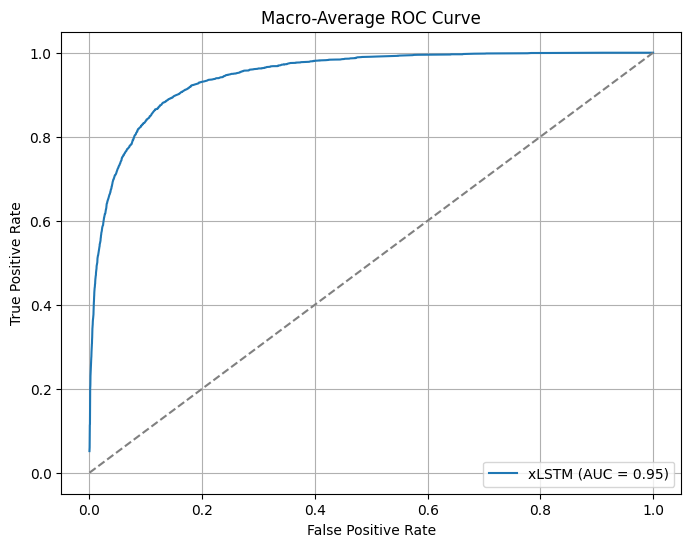

In [7]:
# Plot macro-average ROC
fpr, tpr, macro_auc = compute_macro_roc(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'xLSTM (AUC = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Macro-Average ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

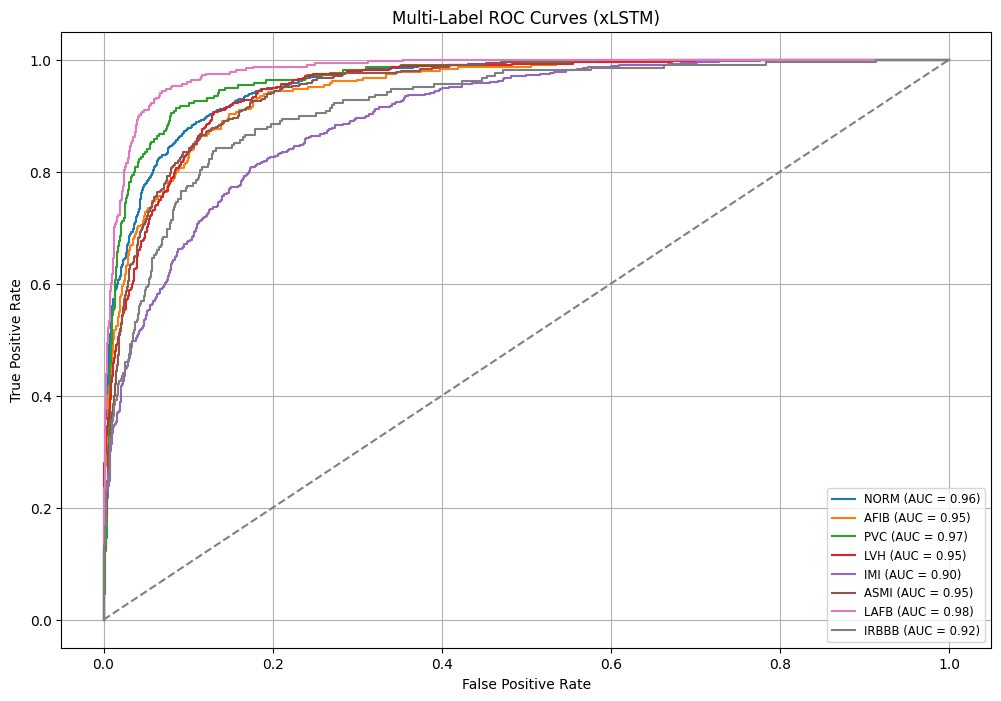

In [8]:
# --- ROC Curves ---
plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (xLSTM)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()

In [9]:
import numpy as np

# After evaluation
np.save("y_true_xlstm.npy", y_true)
np.save("y_pred_xlstm.npy", y_pred)
